# Team as an entity model

This model is a

In [38]:
# Import
from torch import nn
from torch.utils.data import DataLoader

from models.models import *
from datasets.datasets import *
from utils import *

In [39]:
# Meta
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
print(f"Device: {device}")

Device: cuda


# Dataset

In [88]:
dataset = get_player_dataset(NL=[5])

reading file
Loaded 13794 rows.
Normalizing features
Loading player data
creating dataset structure
creating player dict


# Dataloader

In [89]:
batch_size = 100

N_datasets = dataset.random_split(0.1)

#concatenate all datasets together

all_datasets_train = []
for i in range(len(N_datasets)):
    all_datasets_train += N_datasets[i][1]
all_datasets_test = []
for i in range(len(N_datasets)):
    all_datasets_test += N_datasets[i][2]

dataset_train = PlayerDataset(all_datasets_train, max_N=5)
dataset_test = PlayerDataset(all_datasets_test, max_N=5)

print(f"Train size: {len(dataset_train)}")
print(f"Test size: {len(dataset_test)}")

# Must generate batches of sequence data with the following format:
# (batch_size, num_seasons(N), input_size(num stats))
# (https://stackoverflow.com/questions/49466894/how-to-correctly-give-inputs-to-embedding-lstm-and-linear-layers-in-pytorch/49473068#49473068)
dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
dataloader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=True)

print(dataset_train.__getitem__(0))

Train size: 3256
Test size: 334
(tensor([[ 0.3646,  0.8894,  0.7829,  1.2073,  1.0398, -0.1525,  0.5220,  0.3623,
          0.7670,  0.5557,  0.6913],
        [ 0.5947, -1.4056, -0.1871, -0.2150, -0.1664,  0.4403, -0.7184, -0.3949,
         -0.3073,  0.0700, -0.9768],
        [ 0.8249,  1.2072,  0.4249,  0.5363,  0.5035, -2.0295,  0.6412, -1.0616,
          0.1922, -0.7603,  0.5293],
        [ 1.0550,  1.2072,  1.1886,  0.9552,  1.0057, -0.6465,  0.4013,  0.7785,
          0.9632,  1.7306,  0.8515],
        [ 1.2852,  1.1719,  1.2770,  0.8868,  1.0057,  0.4403,  0.5220,  0.8718,
          1.2665,  1.3860,  0.7150]]), tensor([ 1.5153,  1.2072,  0.8536,  0.7302,  0.7605, -0.4489,  0.0750,  0.1641,
         0.7670,  1.1676,  0.5664]))


Text(0.5, 1.0, 'Mutual Information between Stats')

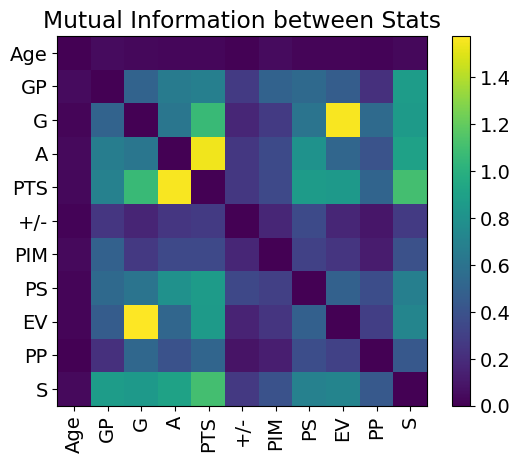

In [121]:
from sklearn.feature_selection import mutual_info_regression
#look at mutual information between stats from current season to N seasons ago

mutual_info = np.zeros((11,11))
raw_data = dataset.all_data_normalized.drop(columns=['Rk','Player', 'Season','Tm', 'Pos','SH','GW','EV.1','PP.1','SH.1','S%','TOI','ATOI'],axis=1).values
for j in range(len(raw_data[0])):
    mi = mutual_info_regression(raw_data,raw_data[:,j])
    mutual_info[j] = mi

#remove diagonal
np.fill_diagonal(mutual_info,0)

plt.imshow(mutual_info)
plt.colorbar()
plt.xticks(np.arange(11),dataset.all_data_normalized.drop(columns=['Rk','Player', 'Season','Tm', 'Pos','SH','GW','EV.1','PP.1','SH.1','S%','TOI','ATOI'],axis=1).columns,rotation=90)
plt.yticks(np.arange(11),dataset.all_data_normalized.drop(columns=['Rk','Player', 'Season','Tm', 'Pos','SH','GW','EV.1','PP.1','SH.1','S%','TOI','ATOI'],axis=1).columns)
plt.title('Mutual Information between Stats')

torch.Size([3256, 5, 11])


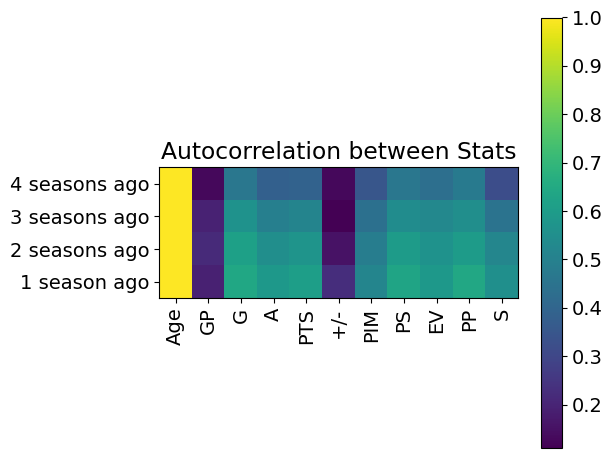

In [160]:
#measure autocorrelation

stacked_data = torch.stack([dataset_train.data[i][0] for i in range(len(dataset_train))])
stacked_data_target = torch.stack([dataset_train.data[i][1] for i in range(len(dataset_train))])
print(stacked_data.shape)

autocorr = np.zeros((4,11))
for i in range(4):
    for j in range(11):
        autocorr[i,j] = np.corrcoef(stacked_data[:,i,j],stacked_data_target[:,j])[0,1]

plt.imshow(autocorr)
plt.title('Autocorrelation between Stats')
plt.colorbar()
plt.xticks(np.arange(11),dataset.all_data_normalized.drop(columns=['Rk','Player', 'Season','Tm', 'Pos','SH','GW','EV.1','PP.1','SH.1','S%','TOI','ATOI'],axis=1).columns,rotation=90)
plt.yticks(np.arange(4),['4 seasons ago','3 seasons ago','2 seasons ago','1 season ago'])
plt.tight_layout()
            
    


# Training and Validation

In [73]:
# NOTE: N will be variable, as the input size
input_size = len(dataset_train.__getitem__(0)[0][0])
print(f"Input size: {input_size}")
hidden_size = 11
MLP_hidden_size = 11
num_layers = 1
model = PlayerStandalone(input_size=input_size, hidden_size=hidden_size, MLP_hidden_size=MLP_hidden_size, num_layers=num_layers, device=device).to(device)
model_linear = PlayerLinear(input_size=input_size, N=5, device=device).to(device)

Input size: 11


In [74]:
criterion = RMSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.0001)
epochs = 50
loss_interval = 5

In [75]:
(model, train_losses, val_losses) = train_and_validate(model, criterion, optimizer, dataloader_train, dataloader_test, epochs=epochs, loss_interval=loss_interval, device=device)

0 th epoch :  0.9690572683819495
Validation loss for epoch 0: 0.8991750225876317
Validation loss for epoch 5: 0.75130864165046
10 th epoch :  0.7024439039546023
Validation loss for epoch 10: 0.7121220447800376
Validation loss for epoch 15: 0.6923987504207727
20 th epoch :  0.6742908063665916
Validation loss for epoch 20: 0.6837747422131625
Validation loss for epoch 25: 0.6760212833231146
30 th epoch :  0.6650335107530866
Validation loss for epoch 30: 0.6732019980748495
Validation loss for epoch 35: 0.6725575923919678
40 th epoch :  0.6591538695508179
Validation loss for epoch 40: 0.6657910943031311
Validation loss for epoch 45: 0.6637777758367134


In [76]:
criterion_linear = RMSELoss()
optimizer_linear = torch.optim.Adam(model_linear.parameters(),lr=0.01)
epochs_linear = 50
loss_interval_linear = 5

In [77]:
(model_linear, train_losses_linear, val_losses_linear) = train_and_validate(model_linear, criterion_linear, optimizer_linear, dataloader_train, dataloader_test, epochs=epochs_linear, loss_interval=loss_interval_linear, device=device)

0 th epoch :  0.6751905831310392
Validation loss for epoch 0: 0.661144368576281
Validation loss for epoch 5: 0.6698911388715109
10 th epoch :  0.6591251735487882
Validation loss for epoch 10: 0.6698780439116738
Validation loss for epoch 15: 0.6637787999528827
20 th epoch :  0.6589418485604928
Validation loss for epoch 20: 0.6664014422532284
Validation loss for epoch 25: 0.6662602894233934
30 th epoch :  0.6596174281648642
Validation loss for epoch 30: 0.6635626193248865
Validation loss for epoch 35: 0.6679602265357971
40 th epoch :  0.6595148140960454
Validation loss for epoch 40: 0.6664045778187838
Validation loss for epoch 45: 0.6663884412158619


In [78]:
#average results
avg_predictions = []
avg_targets = []
for step, (x,y) in enumerate(dataset_train):
    #drop all padded zeros
    x = x[x.sum(dim=1) != 0]
    avg_predictions.append(torch.mean(x, dim=0)) 
    avg_targets.append(y)

avg_predictions = torch.stack(avg_predictions)
avg_targets = torch.stack(avg_targets)
avg_loss = criterion(avg_predictions, avg_targets)

# Plot Results

Average loss: 0.7531512975692749


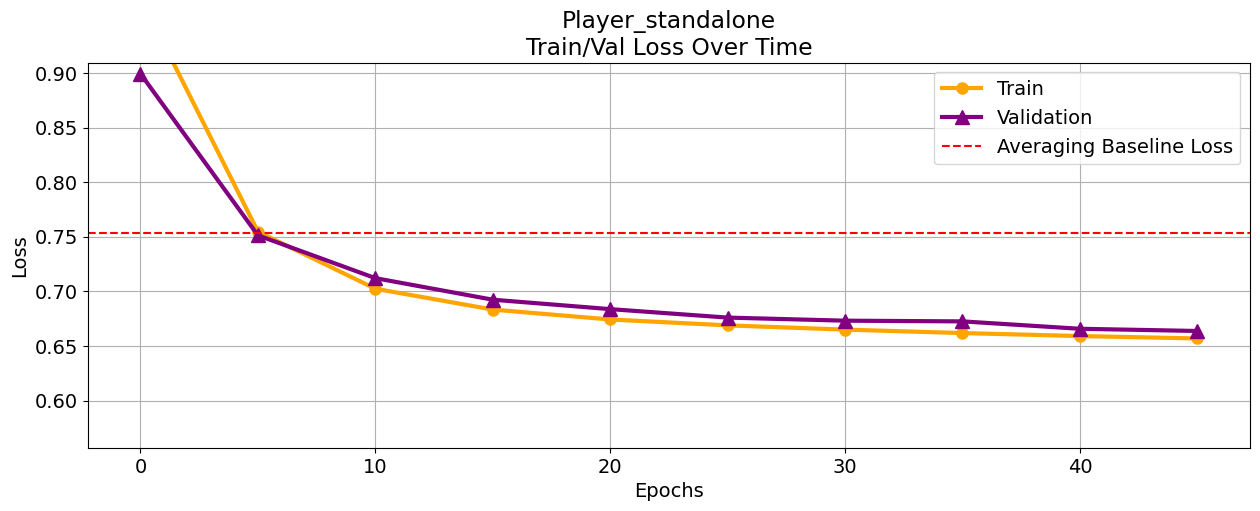

In [79]:
print(f"Average loss: {avg_loss}")
plot_train_v_loss("Player_standalone",train_losses, val_losses, loss_interval, baseline_loss=avg_loss)


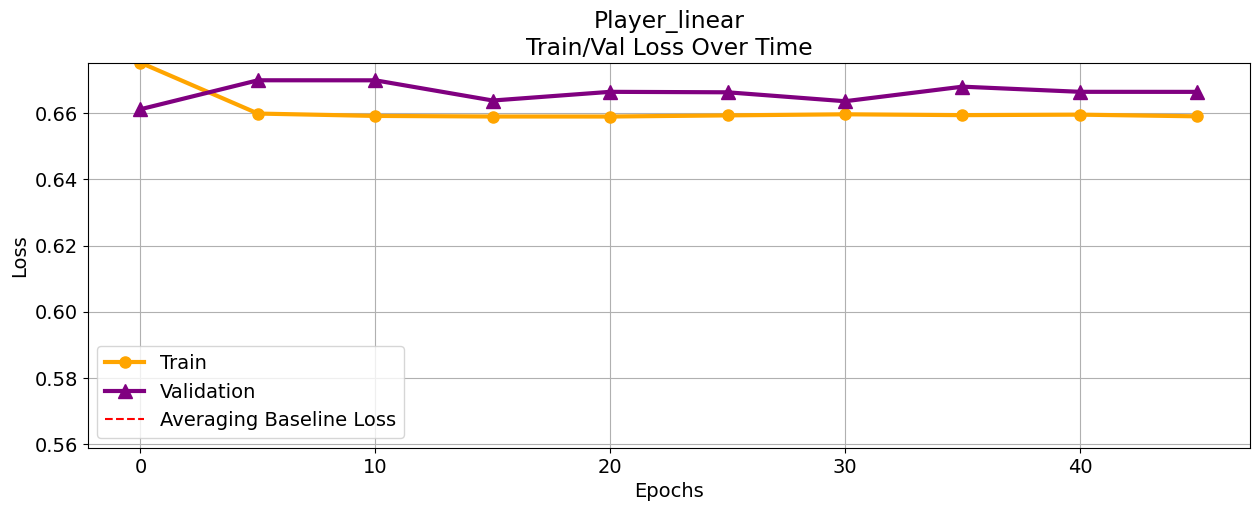

In [80]:
plot_train_v_loss("Player_linear",train_losses_linear, val_losses_linear, loss_interval, baseline_loss=avg_loss)

In [81]:
# Define loss
def Ind_RMSELoss(yhat, y):
    return torch.sqrt(torch.mean((yhat-y)**2,axis=0))

In [82]:
avg_loss_ind = Ind_RMSELoss(avg_predictions, avg_targets)
print(f"Average loss individual: {avg_loss_ind}")

sample =dataset_train.__getitem__(0)
print(sample[1])
print(dataset.unnormalize(sample[1]))


pred_sample = model(sample[0].unsqueeze(0).to(device))
print(dataset.unnormalize(pred_sample.cpu().detach()))

pred_sample_linear = model_linear(sample[0].unsqueeze(0).to(device))
print(dataset.unnormalize(pred_sample_linear.cpu().detach()))

Average loss individual: tensor([0.4321, 0.8156, 0.6776, 0.6704, 0.6477, 1.2296, 0.6961, 0.7336, 0.7202,
        0.7729, 0.6396])
tensor([-1.0162, -1.4056, -1.4110, -1.1158, -1.2937,  0.0451, -0.9613, -0.9924,
        -1.3815, -0.7603, -0.9115])
tensor([ 2.2000e+01,  8.0000e+00, -1.1921e-07,  1.0000e+00,  1.0000e+00,
         0.0000e+00,  4.0000e+00, -2.3842e-07, -1.1921e-07,  0.0000e+00,
         1.0000e+01])
tensor([[22.7565, 26.0389,  1.1457,  1.9734,  2.8351, -1.8639,  7.3324,  0.5880,
          0.8873,  0.2902, 11.7942]])
tensor([[21.9865, 25.5067,  0.8795,  1.8667,  2.5609, -2.0591, 10.4111,  0.3555,
          0.8572,  0.0696, 10.7388]])


# Exploration results

Exploration 

In [83]:
test_preds = []
test_targets = []
test_avg_baseline = []
test_avg_baseline_linear = []



for step, (x,y) in enumerate(dataset_train): 
    pred = model(x.unsqueeze(0).to(device))[0]
    test_preds.append(pred.cpu().detach())
    test_targets.append(y)
    pred_linear = model_linear(x.unsqueeze(0).to(device))[0]
    test_avg_baseline_linear.append(pred_linear.cpu().detach())
    #drop all padded zeros
    x = x[x.sum(dim=1) != 0]
    test_avg_baseline.append(torch.mean(x, dim=0))

    
    
#stack all the tensors
test_preds = torch.stack(test_preds)
test_targets = torch.stack(test_targets)
test_avg_baseline = torch.stack(test_avg_baseline)
test_avg_baseline_linear = torch.stack(test_avg_baseline_linear)


    
preds_n_targets = (test_targets, test_preds, test_avg_baseline, test_avg_baseline_linear)

#unnormalize
#preds_n_targets = (dataset.unnormalize(preds_n_targets[0]), dataset.unnormalize(preds_n_targets[1]), dataset.unnormalize(preds_n_targets[2]), dataset.unnormalize(preds_n_targets[3]))


In [84]:
print(preds_n_targets[3].shape)

torch.Size([28662, 11])


In [85]:
def plot_correlation(pred_n_targets_dict, criterion, stat_names):
    """
    Plots the divergence between the predictions and the targets. It includes the max positive and negative deviations.

    NL: list of the N values used for targets/preds
    pred_n_targets_dict: dictionary where each entry is an N from NL and contains the list of all target/prediction pairs
    criterion: loss function object

    NOTE: NL, targets and preds must all have the same size
    """

    
    y, y_hat, y_base, y_base_avg = pred_n_targets_dict

    for stat_idx in range(len(y[0])):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
        fig.suptitle(f'Predictions for stat: {stat_names[stat_idx]}', fontsize=18)

        #add axis labels
        ax1.set_xlabel("Target")
        ax1.set_ylabel("Prediction")
        ax2.set_xlabel("Target")
        ax2.set_ylabel("Prediction")

        target_stats = y[:, stat_idx]
        preds_stats = y_hat[:, stat_idx]
        baseline_stats = y_base[:, stat_idx]
        
        
        ax1.scatter(target_stats, preds_stats, c="b",s=10)
        ax1.plot(target_stats,target_stats)

       

        # Basline linear
        ax2.scatter(target_stats, baseline_stats, c="b",s=10)
        ax2.plot(target_stats,target_stats)
        
        #annotate with the loss
        loss_per_feature = criterion(preds_stats, target_stats)
        loss_per_feature_base = criterion(baseline_stats, target_stats)
        ax1.annotate(f"Loss: {round(loss_per_feature.item(),4)}", xy=(0.5, 0.1), xycoords='axes fraction')
        ax2.annotate(f"Loss: {round(loss_per_feature_base.item(),4)}", xy=(0.5, 0.1), xycoords='axes fraction')

        
        ax1.grid()
        ax2.grid()
        
        plt.show()

<BarContainer object of 11 artists>

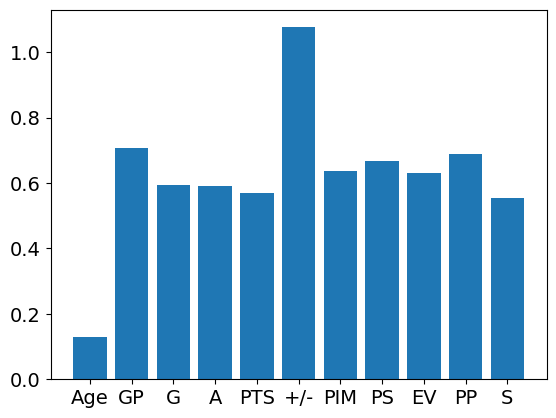

In [86]:
#loss per feature
loss_per_feature = Ind_RMSELoss(preds_n_targets[0], preds_n_targets[1])

plt.bar(dataset.col_names,loss_per_feature)

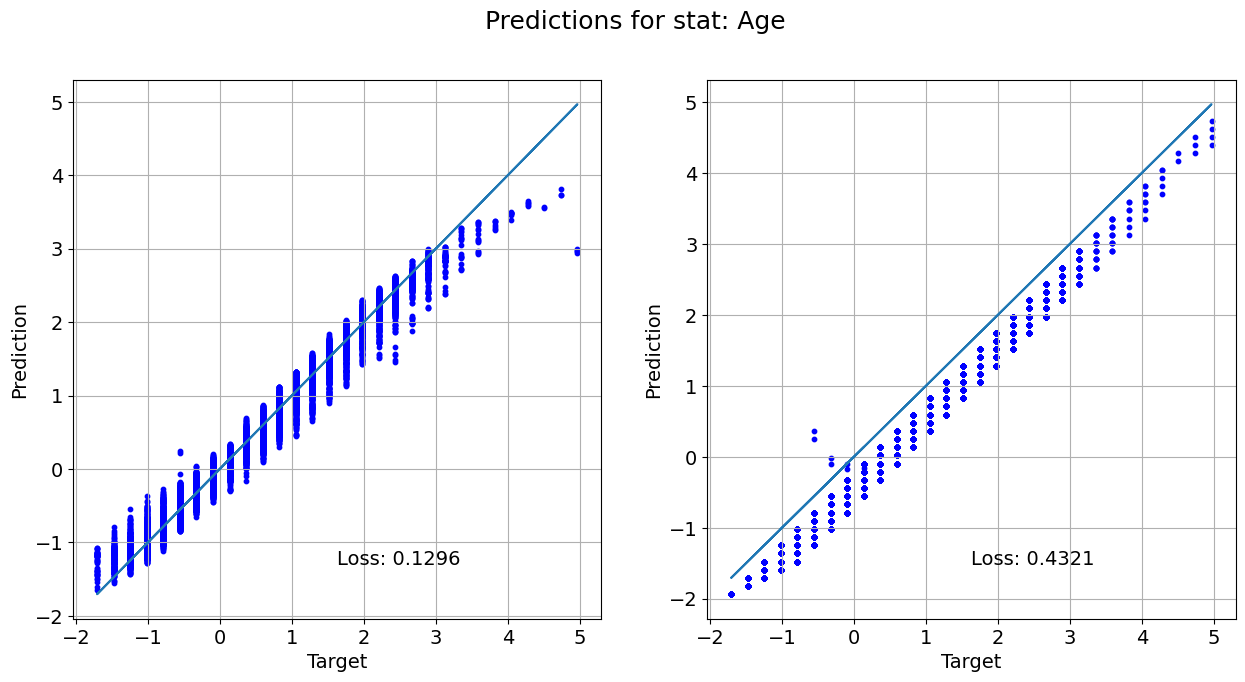

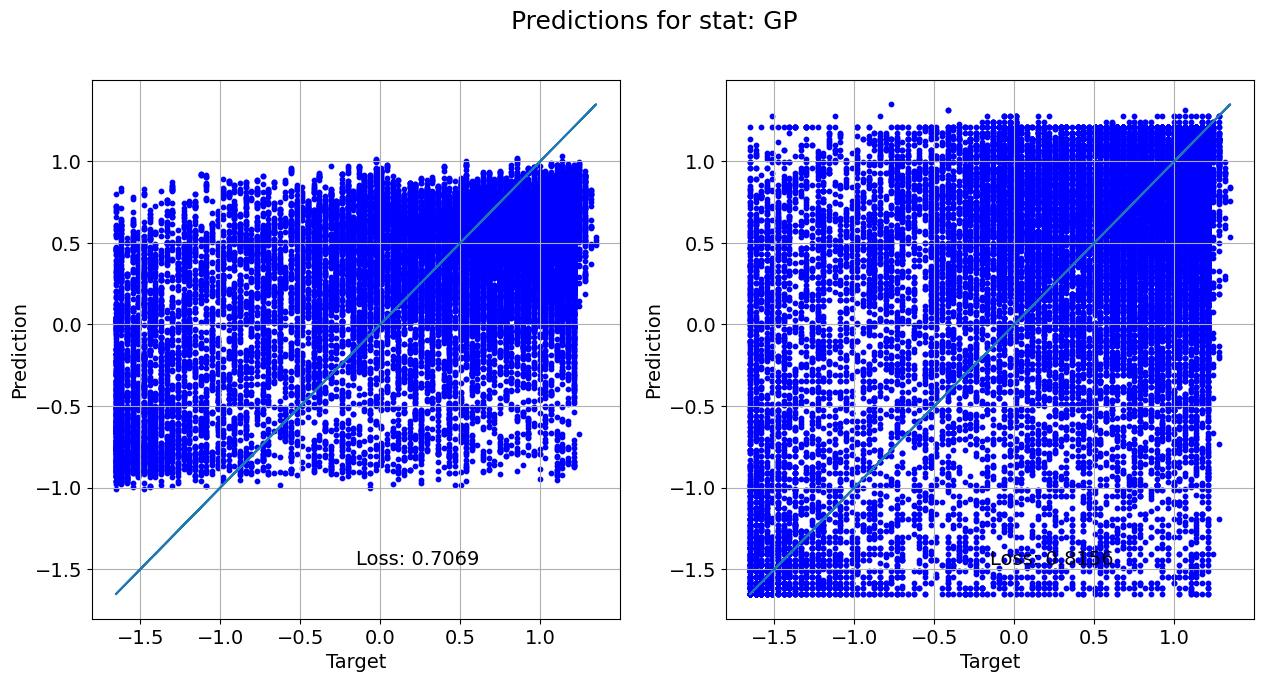

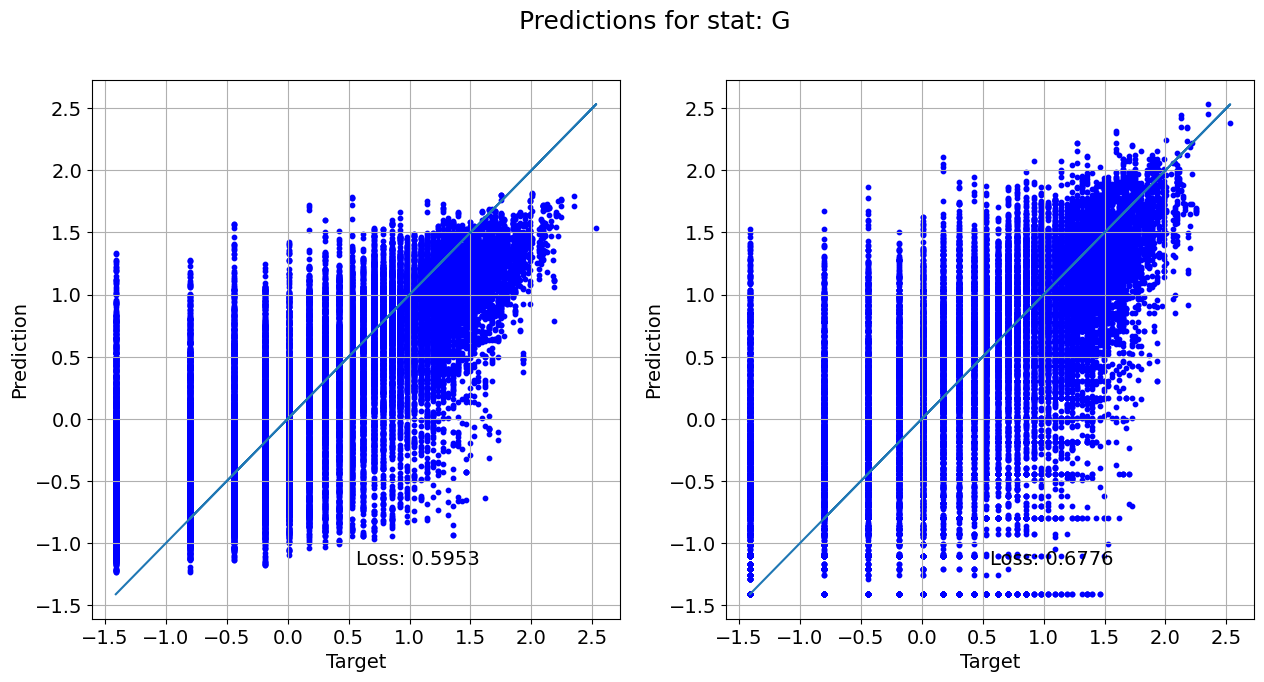

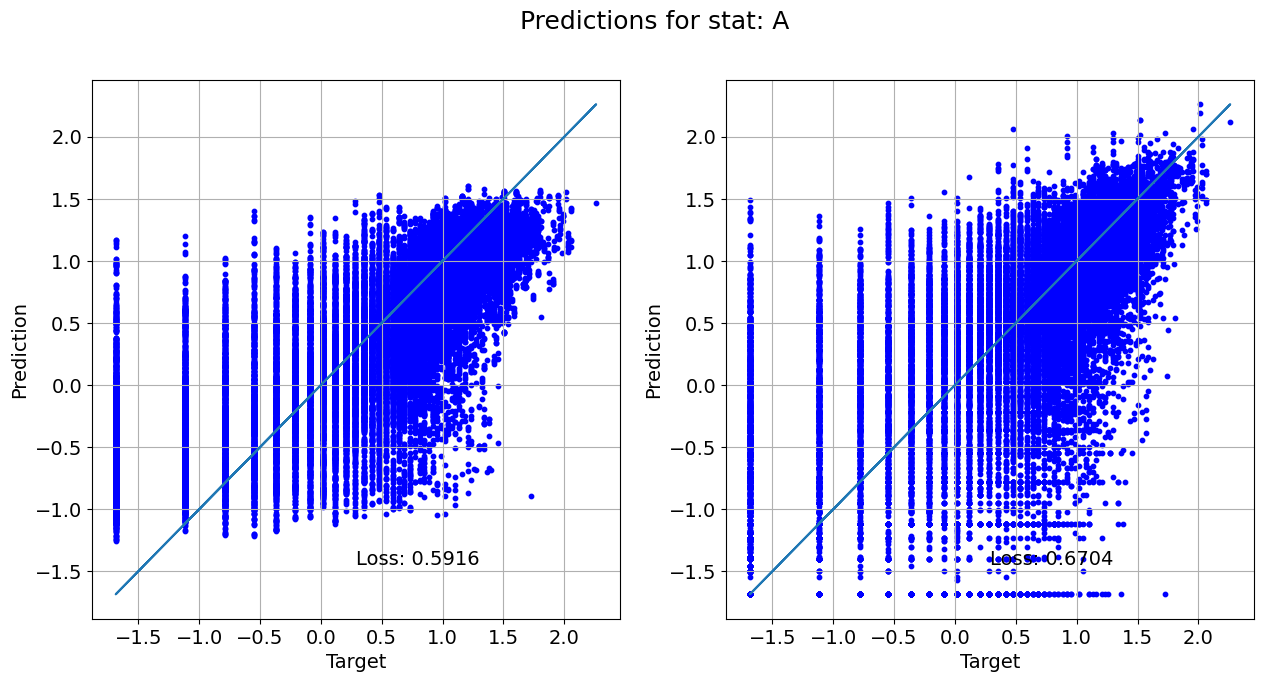

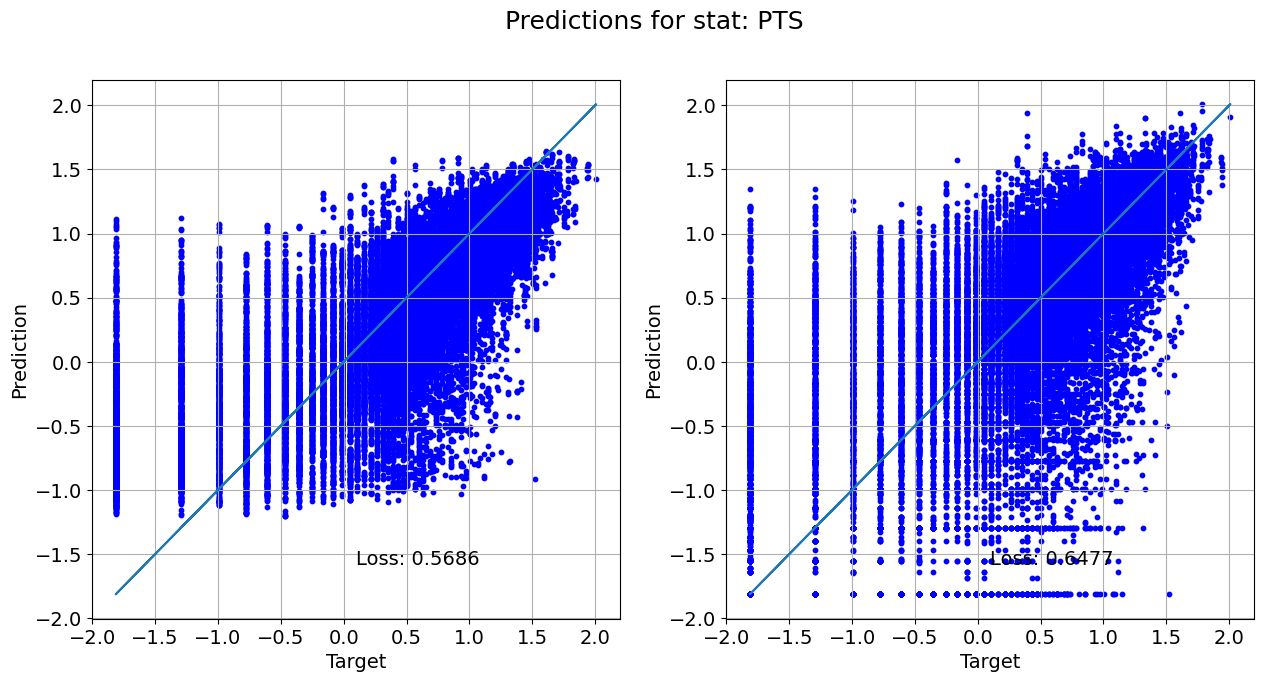

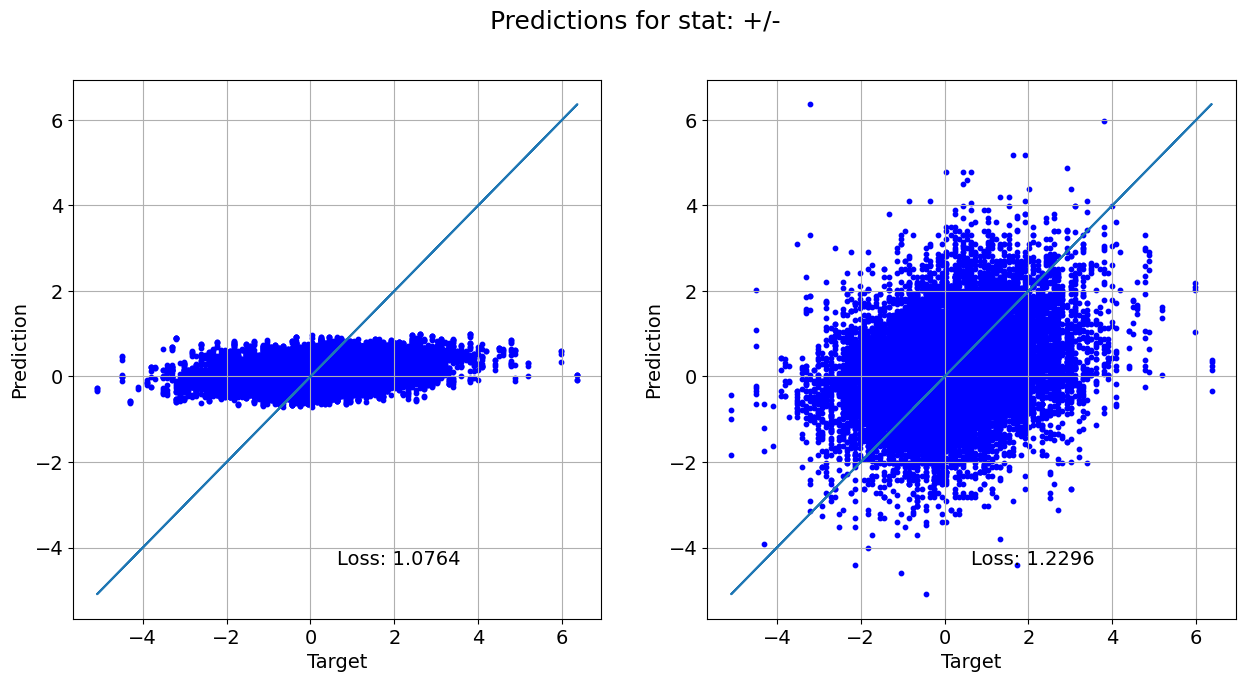

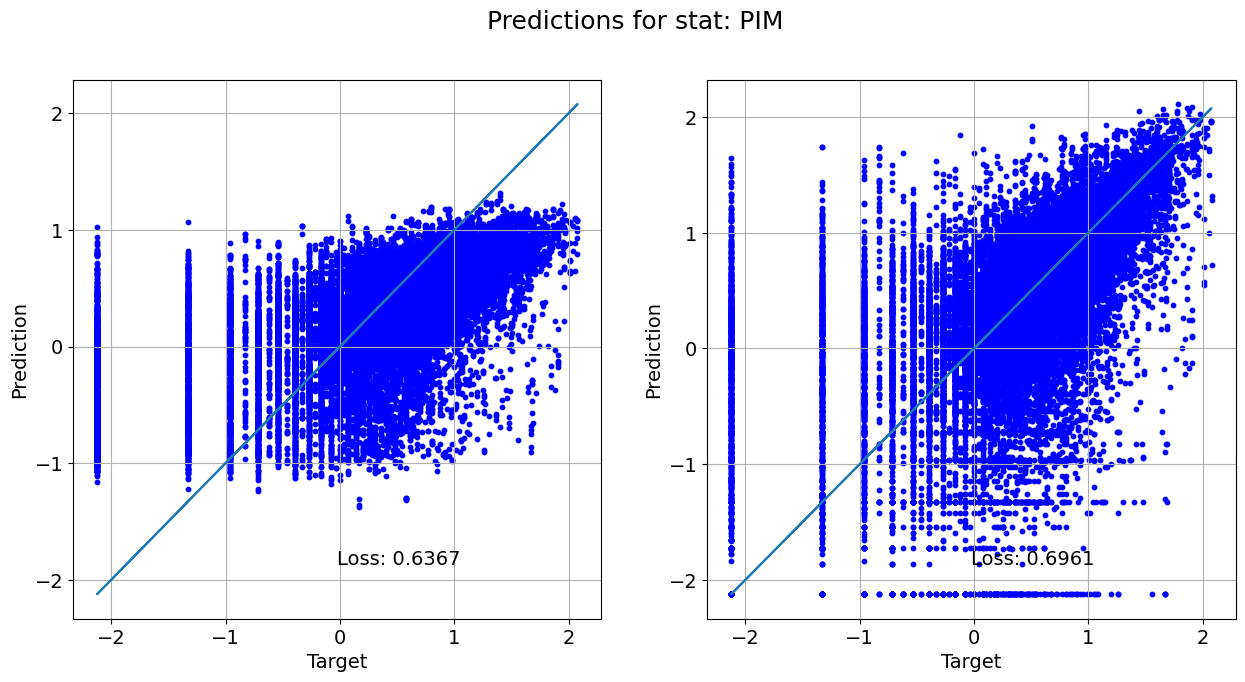

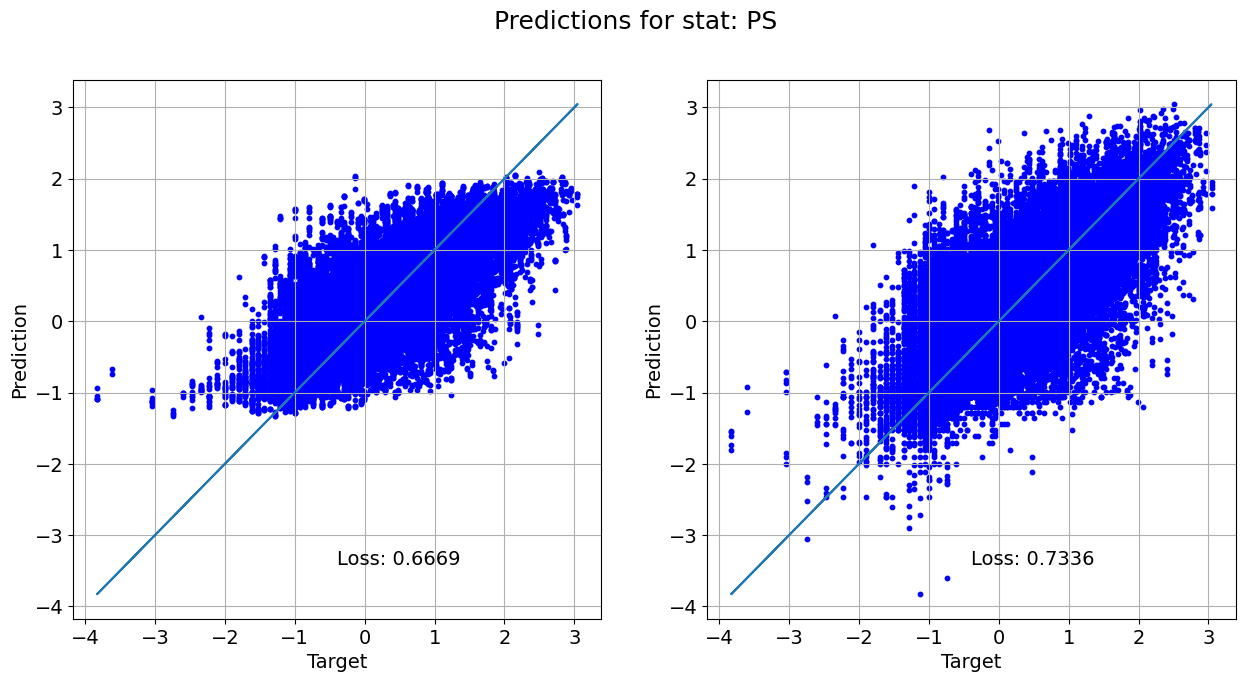

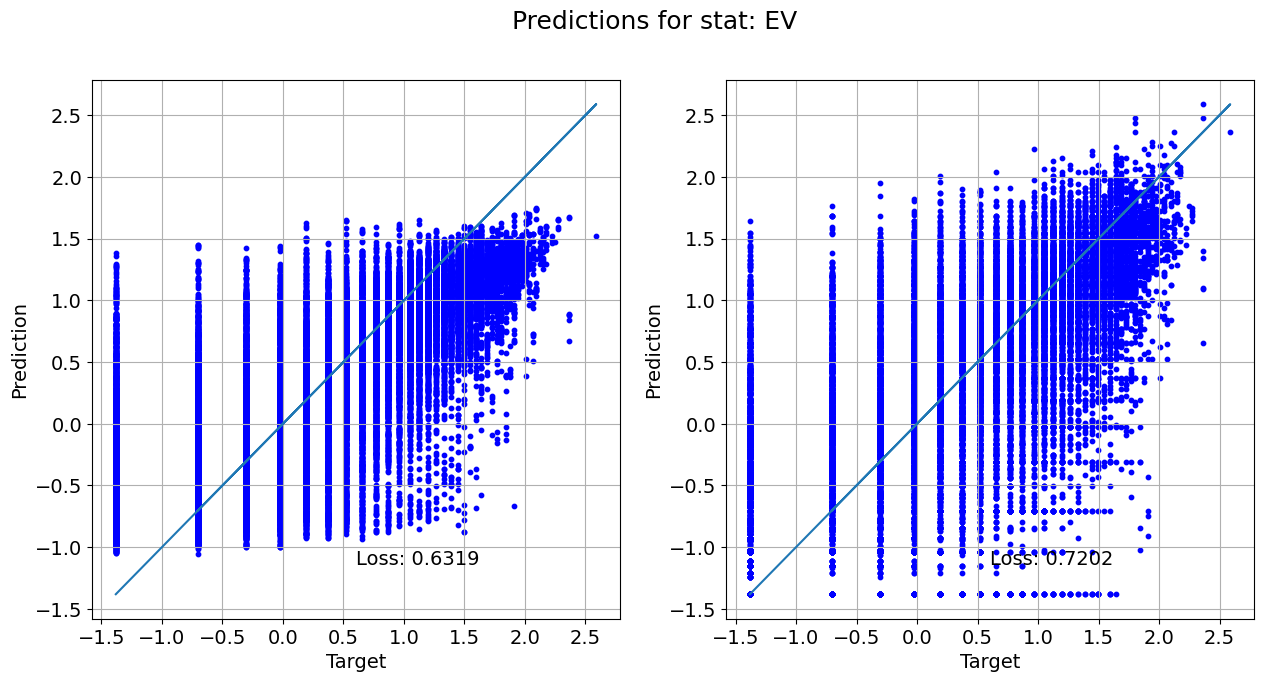

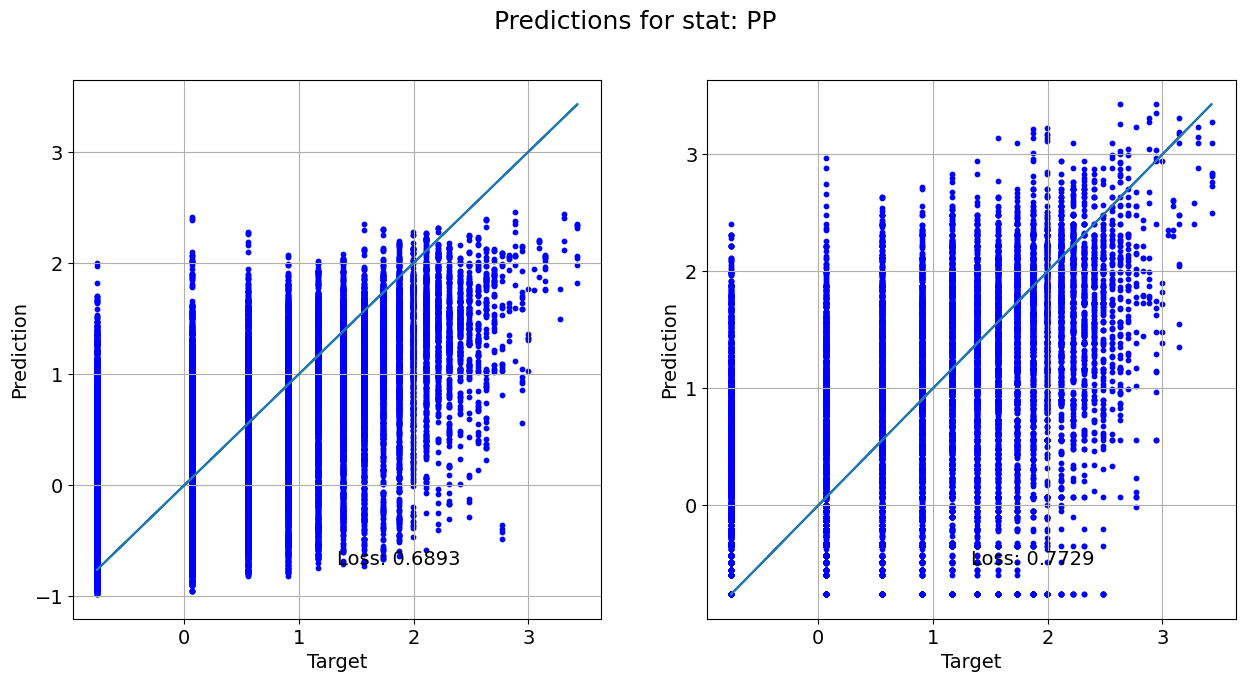

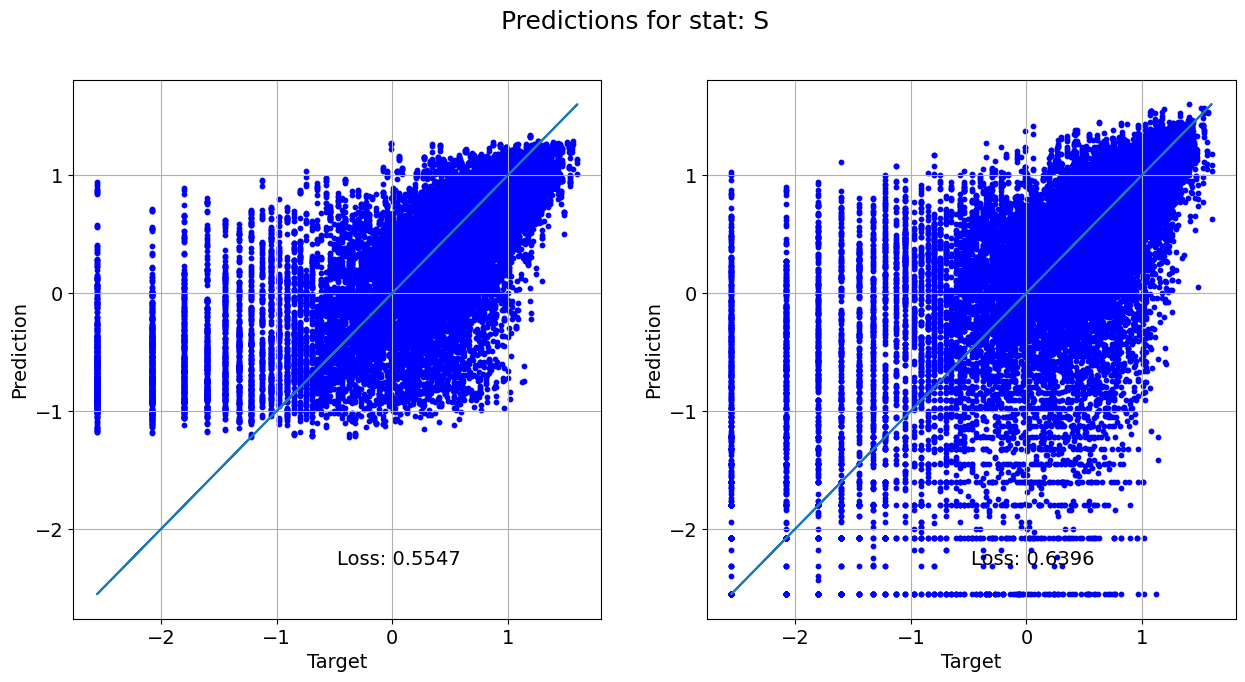

In [87]:
plot_correlation(preds_n_targets, criterion, stat_names=dataset.col_names)

In [128]:
series = []
for step, (x,y) in enumerate(dataset_train):
    plus_minus = torch.cat((x,y.unsqueeze(0)), dim=0)
    series.append(plus_minus[:,5])

avgs = torch.stack(series).mean()

diff = [series[i] - avgs for i in range(len(series))]

print(torch.stack(diff).mean(dim=0))

    

tensor([ 0.0186,  0.0169, -0.0004, -0.0351])
